## Question 15: California Housing Prices
#### 0. Load the California housing dataset using fetch_california_housing from sklearn.datasets.

In [147]:
import pandas as pd

df = pd.read_csv("data/fetch_california_housing.csv", usecols=lambda column: column not in ['Unnamed: 0'])
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### 1. Compute basic statistics using describe.

In [148]:
# 1. Compute basic statistics using describe.
print(df.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population   
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000  \
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         Price  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

#### 2. Assign $(y,X)$

In [149]:
import numpy as np
y = df["Price"]
X = df.drop(columns=['Price'])


#### 3. Split the dataset into training and testing

In [119]:
# 3.

from sklearn.model_selection import train_test_split
import warnings

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# normalize X, keep the dataframes
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)





#### 4. Construct a stepwise procedure and find the best model based on adjusted R-squared criteria. Print the list of feature for the best model.

In [150]:
# 4.
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


def bic_score(estimator, X, y):
    n = X.shape[0]  
    k = X.shape[1] + 1  
    y_pred = estimator.predict(X)
    rss = np.sum((y - y_pred) ** 2) 
    bic = n * np.log(rss / n) + k * np.log(n)
    return -bic  


lin_reg = LinearRegression()

sfs_bic = SFS(
    lin_reg,
    k_features="best",
    forward=True,
    floating=False,
    scoring=bic_score,  
    cv=5  
)
sfs_bic = sfs_bic.fit(X_train, y_train)

bic_best_features = list(sfs_bic.k_feature_names_)
print("Best model features based on BIC:", bic_best_features)


Best model features based on BIC: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']


#### 5. Estimate the linear model using the selected features in statsmodels. Print the results.

In [151]:
# 5. Estimate the linear model using the selected features in statsmodels. Print the results.
import statsmodels.api as sm

X_train_best = X_train[bic_best_features]
X_train_best = sm.add_constant(X_train_best)
model = sm.OLS(y_train, X_train_best)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     3734.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:18:16   Log-Likelihood:                -15847.
No. Observations:               14448   AIC:                         3.171e+04
Df Residuals:                   14441   BIC:                         3.176e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.2290      0.779    -47.798      0.0

#### 6. Any evidence of multicolinearity? If so, provide a remedy.

In [152]:
# Any evidence of multicolinearity? If so, provide a remedy.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_best.columns.drop("const")
vif_data["VIF"] = [variance_inflation_factor(X_train_best.values, i+1) for i in range(X_train_best.shape[1]-1)]
print(vif_data)

     feature       VIF
0     MedInc  2.488828
1   HouseAge  1.111233
2   AveRooms  8.196693
3  AveBedrms  6.928152
4   Latitude  8.974199
5  Longitude  8.695188


#### There are 4 Variance Inflation Factors above 5, indicating a medium Multi-collinearity

#### Remedy 1: we can remove the highly correlated predictors

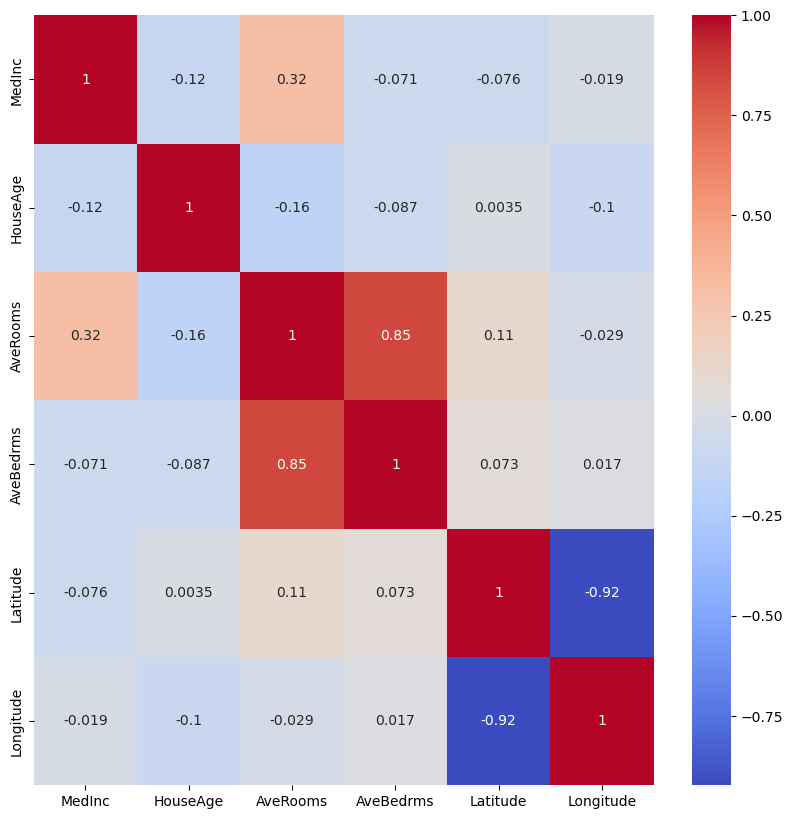

In [153]:
# Remedy 1: we can remove the highly correlated predictors

correlation_matrix = X_train_best.corr()
#print(correlation_matrix.iloc[1:, 1:])

# visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix.iloc[1:, 1:], annot=True, cmap='coolwarm')
plt.show()




In [154]:
# Remove Averoo and Latitude
X_train_reduced = X_train_best.drop(columns=["AveRooms", "Latitude"])

# Re-estimate the model
model_reduced = sm.OLS(y_train, X_train_reduced)
results_reduced = model_reduced.fit()

vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_train_reduced.columns.drop("const")
vif_data_reduced["VIF"] = [variance_inflation_factor(X_train_reduced.values, i+1) for i in range(X_train_reduced.shape[1]-1)]
print('VIF before removing multicolinearity\n', vif_data)
print('VIF after removing multicolinearity\n', vif_data_reduced)
print('BSE before removing multicolinearit\n', results.bse)
print('BSE after removing multicolinearity\n', results_reduced.bse)

VIF before removing multicolinearity
      feature       VIF
0     MedInc  2.488828
1   HouseAge  1.111233
2   AveRooms  8.196693
3  AveBedrms  6.928152
4   Latitude  8.974199
5  Longitude  8.695188
VIF after removing multicolinearity
      feature       VIF
0     MedInc  1.021870
1   HouseAge  1.034532
2  AveBedrms  1.014591
3  Longitude  1.011349
BSE before removing multicolinearit
 const        0.778876
MedInc       0.004994
HouseAge     0.000504
AveRooms     0.007037
AveBedrms    0.035469
Latitude     0.008458
Longitude    0.008878
dtype: float64
BSE after removing multicolinearity
 const        0.404025
MedInc       0.003578
HouseAge     0.000544
AveBedrms    0.015177
Longitude    0.003385
dtype: float64


#### The ViFs and BSEs are reduced.

#### There are also other remedies such as PCA, Ridge Regression and collecting more data.




### 7. Any evidence of heteroskedasticity?
Based on the output below, the standard errors for the coefficients HC0, HC1, HC2, HAC are generally larger than the standard errors in the Standard OLS model. Therefore, it suggests potential heteroskedasticity in the model.

In [158]:
coefficients = X_train_best.columns[1:]
results_comparison = {}

for beta in coefficients:
    # Standard OLS results
    results_standard =results.summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]

    # Heteroskedasticity-robust (HC) adjustments
    results_hc0 = results.get_robustcov_results(cov_type='HC0').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hc1 = results.get_robustcov_results(cov_type='HC1').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hc2 = results.get_robustcov_results(cov_type='HC2').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hac = results.get_robustcov_results(cov_type='HAC', maxlags=1).summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]

    # Combine results into a DataFrame for comparison
    results_comparison[beta] = pd.DataFrame({
        'Standard OLS': results_standard,
        'HC0': results_hc0,
        'HC1': results_hc1,
        'HC2': results_hc2,
        'HAC': results_hac
    }).T

results_comparison

{'MedInc':                  Coef.  Std.Err.          t  P>|t|
 Standard OLS  0.444223  0.004994  88.949053    0.0
 HC0           0.444223  0.009103  48.799619    0.0
 HC1           0.444223  0.009105  48.787796    0.0
 HC2           0.444223  0.009305  47.742754    0.0
 HAC           0.444223  0.009198  48.295718    0.0,
 'HouseAge':                  Coef.  Std.Err.          t         P>|t|
 Standard OLS  0.009614  0.000504  19.077759  3.732877e-80
 HC0           0.009614  0.000568  16.939311  9.516402e-64
 HC1           0.009614  0.000568  16.935207  1.019003e-63
 HC2           0.009614  0.000569  16.900385  1.819368e-63
 HAC           0.009614  0.000565  17.022654  2.364788e-64,
 'AveRooms':                  Coef.  Std.Err.          t         P>|t|
 Standard OLS -0.120462  0.007037 -17.119545  4.648015e-65
 HC0          -0.120462  0.013258  -9.085663  1.162509e-19
 HC1          -0.120462  0.013262  -9.083462  1.186134e-19
 HC2          -0.120462  0.013752  -8.759582  2.174974e-18
 HA

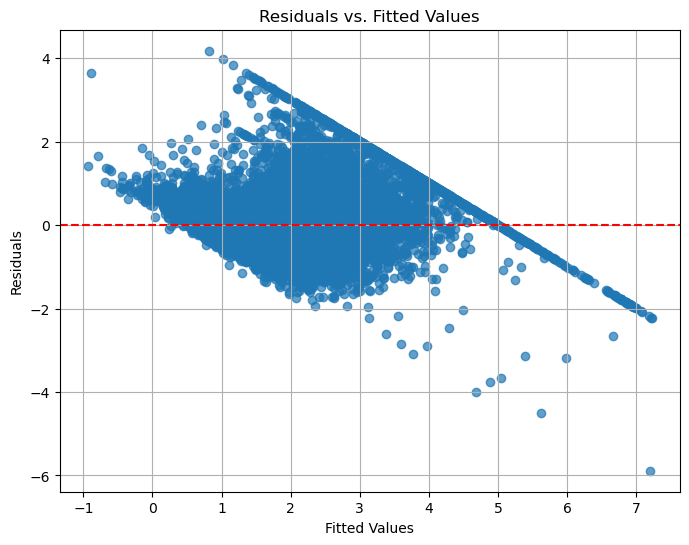

In [159]:


import matplotlib.pyplot as plt

# Residuals vs. Fitted values plot
fitted_vals = results.fittedvalues
residuals = results.resid



plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


#### This non-random pattern is also indicative of heteroskedasticity, where the variance of residuals is not constant across the range of fitted values.

### 8. Any evidence that the residuals are not normally distributed?

/Users/liuzirui/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


                     Test Name                Equation    Statistic   
0            Shapiro-Wilk Test  Shapiro-Wilk statistic     0.925548  \
1      Kolmogorov-Smirnov Test            KS statistic     0.093349   
2  D’Agostino’s K-squared Test     K-squared statistic  2953.608465   
3             Jarque-Bera Test            JB statistic  8548.234892   

         p-value   Decision  
0   0.000000e+00  Reject H0  
1  5.093508e-110  Reject H0  
2   0.000000e+00  Reject H0  
3   0.000000e+00  Reject H0  


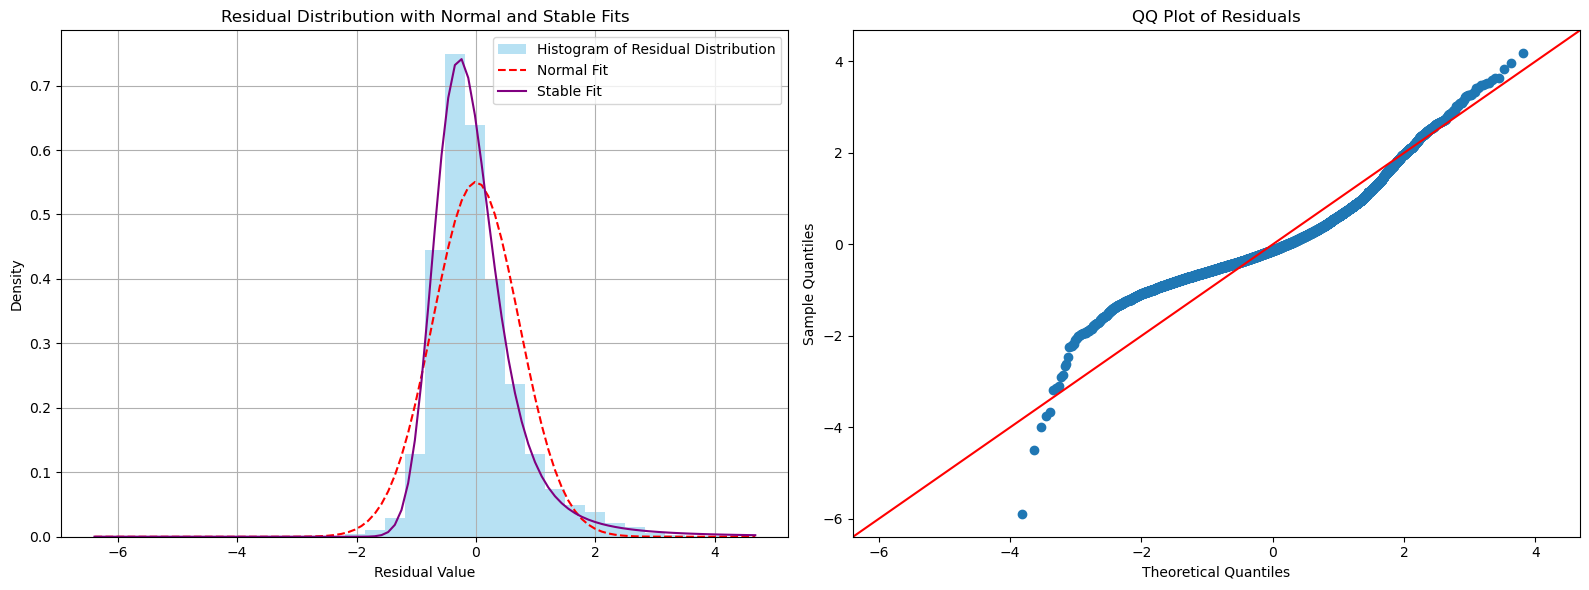

In [162]:
# 8. Any evidence that the residuals are not normally distributed?
import statsmodels.api as sm
from scipy.stats import norm, levy_stable
from scipy.stats import shapiro, kstest, anderson, normaltest, jarque_bera

# Running all specified normality tests on the residuals
residuals = results.resid
test_results = []
# Shapiro-Wilk Test
stat, p_value = shapiro(residuals)
test_results.append({
    "Test Name": "Shapiro-Wilk Test",
    "Equation": r"Shapiro-Wilk statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Kolmogorov-Smirnov Test (against normal distribution)
stat, p_value = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals, ddof=1)))
test_results.append({
    "Test Name": "Kolmogorov-Smirnov Test",
    "Equation": r"KS statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# D’Agostino’s K-squared Test
stat, p_value = normaltest(residuals)
test_results.append({
    "Test Name": "D’Agostino’s K-squared Test",
    "Equation": r"K-squared statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Jarque-Bera Test
stat, p_value = jarque_bera(residuals)
test_results.append({
    "Test Name": "Jarque-Bera Test",
    "Equation": r"JB statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

print(pd.DataFrame(test_results))
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of the residuals with normal and stable fits
axs[0].hist(residuals, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram of Residual Distribution')

# Normal fit on the histogram
mu, std = norm.fit(residuals)
xmin, xmax = axs[0].get_xlim()
x_values = np.linspace(xmin, xmax, 100)
p_norm = norm.pdf(x_values, mu, std)
axs[0].plot(x_values, p_norm, 'r--', label='Normal Fit')

# Stable fit on the histogram
alpha_hat, beta_hat, loc_hat, scale_hat = levy_stable._fitstart(residuals)
p_stable = levy_stable.pdf(x_values, alpha_hat, beta_hat, loc=loc_hat, scale=scale_hat)
axs[0].plot(x_values, p_stable, 'purple', linestyle='-', label='Stable Fit')

axs[0].set_xlabel("Residual Value")
axs[0].set_ylabel("Density")
axs[0].set_title("Residual Distribution with Normal and Stable Fits")
axs[0].legend()
axs[0].grid(True)

# QQ plot of the residuals
axs[1].set_title("QQ Plot of Residuals")
sm.qqplot(residuals, line='45', ax=axs[1])

# Display the plots
plt.tight_layout()
plt.show()


#### The test results and plot shows that the residuals are not normally distributed.


### 9. Use the natural logarithm of the price as the dependent variable. Rerun steps 1-6 and describe how your answer changes.

In [163]:
### 9. Use the natural logarithm of the price as the dependent variable. Rerun steps 1-6 and describe how your answer changes.
df['Price_Log'] = np.log(df['Price'])
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price,Price_Log
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1.509839
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1.276758
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1.258745
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1.227592
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1.230225


In [164]:
y_log = df["Price_Log"]
X = df.drop(columns=['Price','Price_Log'])
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)



def bic_score(estimator, X, y):
    n = X.shape[0]  
    k = X.shape[1] + 1  
    y_pred = estimator.predict(X)
    rss = np.sum((y - y_pred) ** 2) 
    bic = n * np.log(rss / n) + k * np.log(n)
    return -bic  


lin_reg = LinearRegression()

sfs_log = SFS(
    lin_reg,
    k_features="best",
    forward=True,
    floating=False,
    scoring=bic_score,  
    cv=5  
)

sfs_log = sfs_log.fit(X_train, y_train_log )

log_best_features = list(sfs_log.k_feature_names_)
print("Best model features based on BIC:", log_best_features)

Best model features based on BIC: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']


In [165]:
# Estimate the linear model using the selected features in statsmodels. Print the results.
import statsmodels.api as sm

X_train_best_log = X_train[log_best_features]
X_train_best_log = sm.add_constant(X_train_best_log)
model_log = sm.OLS(y_train_log, X_train_best_log)
results_log = model_log.fit()
print(results_log.summary())


                            OLS Regression Results                            
Dep. Variable:              Price_Log   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     3860.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:25:42   Log-Likelihood:                -5443.6
No. Observations:               14448   AIC:                         1.090e+04
Df Residuals:                   14441   BIC:                         1.095e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.2862      0.379    -64.065      0.0

### Multicolinearity



In [166]:
# Any evidence of multicolinearity? If so, provide a remedy.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data_log = pd.DataFrame()
vif_data_log["feature"] = X_train_best_log.columns.drop("const")
vif_data_log["VIF"] = [variance_inflation_factor(X_train_best_log.values, i+1) for i in range(X_train_best_log.shape[1]-1)]
print(vif_data)
print(vif_data_log)

     feature       VIF
0     MedInc  2.488828
1   HouseAge  1.111233
2   AveRooms  8.196693
3  AveBedrms  6.928152
4   Latitude  8.974199
5  Longitude  8.695188
     feature       VIF
0     MedInc  2.488828
1   HouseAge  1.111233
2   AveRooms  8.196693
3  AveBedrms  6.928152
4   Latitude  8.974199
5  Longitude  8.695188


#### The multicolinearity reamins the same with 6., and can be solved with the same remedy.

### Heteroskedasticity

The standard errors have decreased compared to when using the price as the dependent variable. However, the standard errors for the HC0, HC1, HC2, and HAC coefficients are still generally larger than those in the standard OLS model. This suggests potential heteroskedasticity in the model.

In [168]:
# 7. Investigating the evidence of heteroskedasticity
coefficients = X_train_best_log.columns[1:]
results_comparison = {}

for beta in coefficients:
    # Standard OLS results
    results_standard = results_log.summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]

    # Heteroskedasticity-robust (HC) adjustments
    results_hc0 = results_log.get_robustcov_results(cov_type='HC0').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hc1 = results_log.get_robustcov_results(cov_type='HC1').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hc2 = results_log.get_robustcov_results(cov_type='HC2').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hac = results_log.get_robustcov_results(cov_type='HAC', maxlags=1).summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]

    # Combine results into a DataFrame for comparison
    results_comparison[beta] = pd.DataFrame({
        'Standard OLS': results_standard,
        'HC0': results_hc0,
        'HC1': results_hc1,
        'HC2': results_hc2,
        'HAC': results_hac
    }).T

results_comparison

{'MedInc':                  Coef.  Std.Err.          t  P>|t|
 Standard OLS  0.189806  0.002431  78.086545    0.0
 HC0           0.189806  0.004327  43.864318    0.0
 HC1           0.189806  0.004328  43.853691    0.0
 HC2           0.189806  0.004371  43.420196    0.0
 HAC           0.189806  0.004361  43.522505    0.0,
 'HouseAge':                  Coef.  Std.Err.         t         P>|t|
 Standard OLS  0.002161  0.000245  8.808286  1.413546e-18
 HC0           0.002161  0.000268  8.069139  7.634033e-16
 HC1           0.002161  0.000268  8.067184  7.756667e-16
 HC2           0.002161  0.000268  8.060459  8.193570e-16
 HAC           0.002161  0.000268  8.074880  7.284883e-16,
 'AveRooms':                  Coef.  Std.Err.          t         P>|t|
 Standard OLS -0.039266  0.003425 -11.465228  2.667401e-30
 HC0          -0.039266  0.005712  -6.874120  6.493148e-12
 HC1          -0.039266  0.005713  -6.872455  6.569183e-12
 HC2          -0.039266  0.005822  -6.744664  1.592115e-11
 HAC     

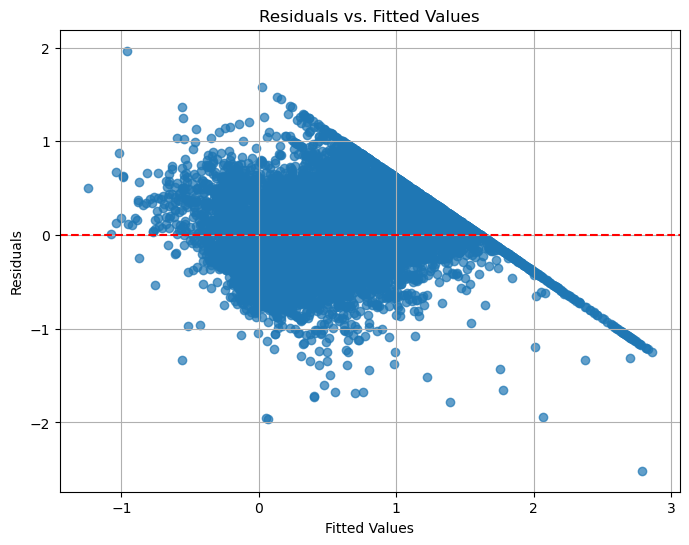

In [169]:
# Residuals vs. Fitted values plot
fitted_vals_log = results_log.fittedvalues
residuals_log = results_log.resid



plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals_log, residuals_log, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


#### Still, this non-random pattern is indicative of heteroskedasticity, where the variance of residuals is not constant across the range of fitted values.

###  Non-normality

                     Test Name                Equation    Statistic   
0            Shapiro-Wilk Test  Shapiro-Wilk statistic     0.990142  \
1      Kolmogorov-Smirnov Test            KS statistic     0.031332   
2  D’Agostino’s K-squared Test     K-squared statistic   419.881100   
3             Jarque-Bera Test            JB statistic  1095.260261   

         p-value   Decision  
0   2.890583e-30  Reject H0  
1   9.335414e-13  Reject H0  
2   6.667724e-92  Reject H0  
3  1.469793e-238  Reject H0  


/Users/liuzirui/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


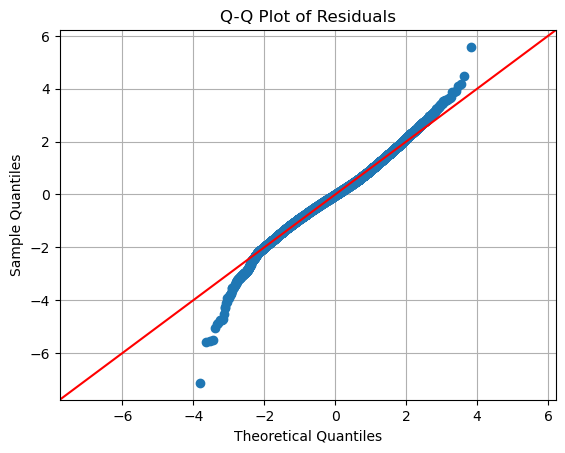

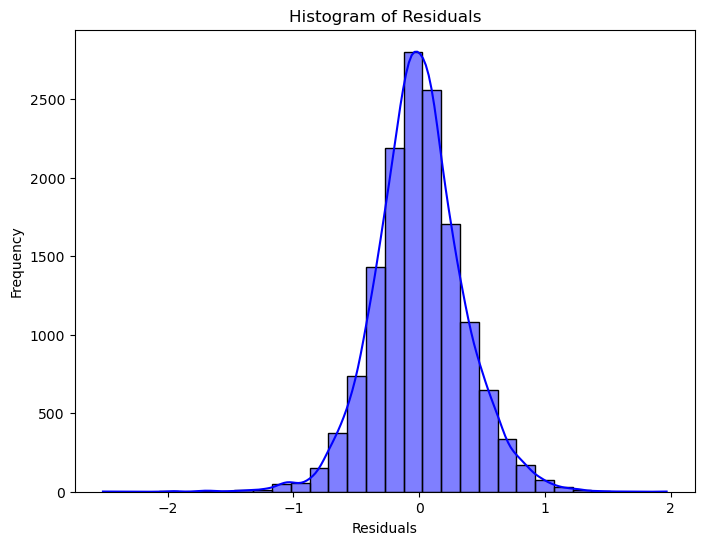

In [172]:
# 8. Any evidence that the residuals are not normally distributed?
import statsmodels.api as sm

from scipy.stats import shapiro, kstest, anderson, normaltest, jarque_bera

# Running all specified normality tests on the residuals
residuals = results_log.resid
test_results_log = []
# Shapiro-Wilk Test
stat, p_value = shapiro(residuals)
test_results_log.append({
    "Test Name": "Shapiro-Wilk Test",
    "Equation": r"Shapiro-Wilk statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Kolmogorov-Smirnov Test (against normal distribution)
stat, p_value = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals, ddof=1)))
test_results_log.append({
    "Test Name": "Kolmogorov-Smirnov Test",
    "Equation": r"KS statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# D’Agostino’s K-squared Test
stat, p_value = normaltest(residuals)
test_results_log.append({
    "Test Name": "D’Agostino’s K-squared Test",
    "Equation": r"K-squared statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Jarque-Bera Test
stat, p_value = jarque_bera(residuals)
test_results_log.append({
    "Test Name": "Jarque-Bera Test",
    "Equation": r"JB statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Displaying results in a flexible DataFrame
test_results_log_df = pd.DataFrame(test_results_log)

print(test_results_log_df)
# Q-Q plot
sm.qqplot(results_log.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()



#### The non-normality of the residuals was mitigated by applying a **log transformation** to the response variable. However, despite this transformation, the residuals still exhibited a **heavy tail** as evidenced by the diagnostics.


### Bonus Qustion:

To address the **heavy tail** issue further, I applied a **GAMLSS model** with a **t-distribution (TF)** (Please refer to the Bonus.html for R details). The t-distribution is more flexible and can better handle heavy tails compared to the normal distribution.


| Statistic                          | Value         |
|------------------------------------|---------------|
| **Mean**                           | 0.01903417    |
| **Variance**                       | 0.999634      |
| **Coefficient of Skewness**        | 0.1270555     |
| **Coefficient of Kurtosis**        | 3.009014      |
| **Filliben Correlation Coefficient** | 0.9987066    |


The quantile residual summary indicates a well-fitting model. A mean close to zero suggests that residuals are centered as expected, while a variance near one shows alignment with the assumed distribution spread for standardized residuals. The skewness coefficient being near zero indicates symmetry in the residuals, which is desirable and implies minimal model misspecification or outliers. A kurtosis close to 3, suggests no extreme tails or outliers, aligning with a normal distribution. Finally, the Filliben correlation coefficient of 0.9987, close to one, supports that the residuals follow the expected normal quantiles, reinforcing the assumption of normality. Together, these metrics confirm that the quantile residuals behave as expected, indicating a strong and adequate model fit.

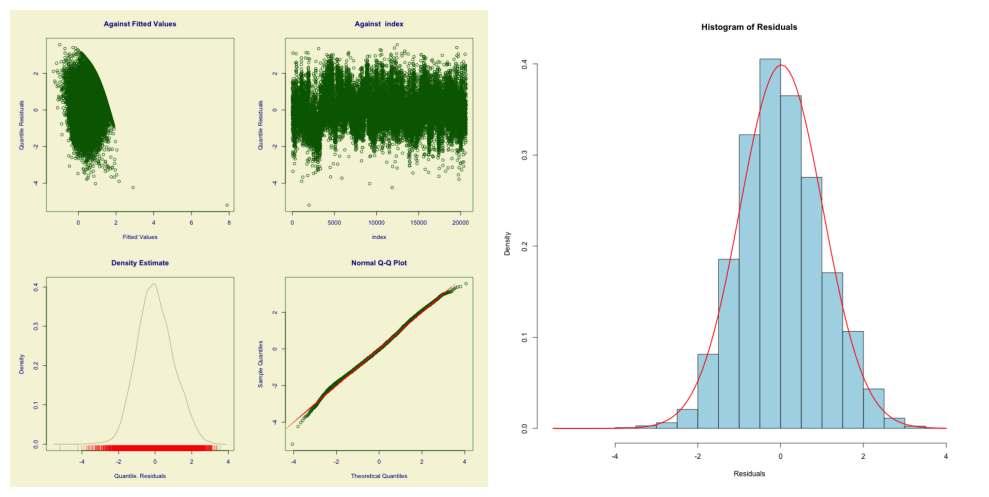

In [138]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img1 = mpimg.imread('output/gamlss-diagnostic-plots.png')
img2 = mpimg.imread('output/gamlss-residuals-histogram.png')

# Display images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(img1)
axs[0].axis('off')  # Hide axes

axs[1].imshow(img2)
axs[1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

### The issue of non-normality in the residuals has been nearly resolved. However, there remain other areas for improvement in the model, such as heteroskedasticity and outliers.